In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Load the data from Google Drive
file_path = '/kaggle/input/titanic/train.csv'
train = pd.read_csv(file_path)
train.head()
np.random.seed(42)

In [53]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: >

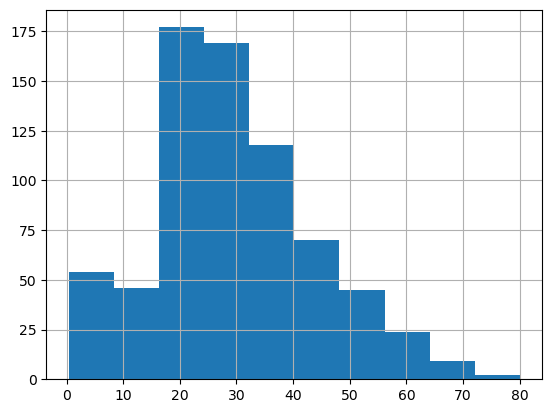

In [54]:
train.Age.hist()

In [55]:
def pre(df,test=False):
    # Drop columns that are not needed for the neural network model
    if test:
        df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    else:
        df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    # Fill missing values in the 'Age' column with the median age
    imputer = SimpleImputer(strategy='median')
    df['Age'] = imputer.fit_transform(df[['Age']])

    # Fill missing values in the 'Embarked' column with the most frequent value
    imputer = SimpleImputer(strategy='most_frequent')
    df['Embarked'] = imputer.fit_transform(df[['Embarked']])

    # Create a new column called 'FamilySize' by adding the 'SibSp' and 'Parch' columns
    df['FamilySize'] = df['SibSp'] + df['Parch']

    # Create a new column called 'IsAlone' that indicates whether the passenger was traveling alone
    df['IsAlone'] = np.where(df['FamilySize'] == 0, 1, 0)

    # Convert categorical variables to one-hot encoding
    encoder = OneHotEncoder()
    cat_vars =['Sex', 'Embarked']
    df_cat = pd.DataFrame(encoder.fit_transform(df[cat_vars]).toarray(), columns=encoder.get_feature_names_out(cat_vars))
    df.drop(cat_vars, axis=1, inplace=True)
    df = pd.concat([df, df_cat], axis=1)

    # Scale numerical variables
    scaler = StandardScaler()
    num_vars = ['Age', 'Fare', 'FamilySize']
    df[num_vars] = scaler.fit_transform(df[num_vars])
    return df

In [56]:
train = pre(train)

In [57]:
# Convert the 'Survived' column to a numpy array
y = train['Survived'].values

# Convert the dataframe to a numpy array
X = train.drop('Survived', axis=1).values

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# # Data Preprocessing
# from sklearn.model_selection import train_test_split

# # Data Preprocessing
# def preparation(data):
#     data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
#     data['Age'] = data.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.mean()))
#     data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
#     data['Fare'] = data['Fare'].fillna(data['Fare'].mean())
#     data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})
#     data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
#     return data

# train = preparation(train)
# # Split the data into features (X) and target (y)
# X = train.drop('Survived', axis=1).values
# y = train['Survived'].values.reshape(-1, 1)

# # Normalize the features
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# 3-layer Neural Network class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.weights1 = np.random.randn(input_size, hidden_size)
        self.bias1 = np.zeros(hidden_size)
        self.weights2 = np.random.randn(hidden_size, output_size)
        self.bias2 = np.zeros(output_size)

    def forward(self, X):
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = self.sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.predictions = self.sigmoid(self.z2)

        return self.predictions

    def backward(self, X, y, learning_rate):
        m = len(X)

        self.dz2 = self.predictions - y
        self.dw2 = (1 / m) * np.dot(self.a1.T, self.dz2)
        self.db2 = (1 / m) * np.sum(self.dz2, axis=0)

        self.da1 = np.dot(self.dz2, self.weights2.T)
        self.dz1 = self.da1 * self.sigmoid_derivative(self.z1)
        self.dw1 = (1 / m) * np.dot(X.T, self.dz1)
        self.db1 = (1 / m) * np.sum(self.dz1, axis=0)

        self.weights2 -= learning_rate * self.dw2
        self.bias2 -= learning_rate * self.db2
        self.weights1 -= learning_rate * self.dw1
        self.bias1 -= learning_rate * self.db1

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def train(self, X_train, y_train, X_val, y_val, num_iterations, learning_rate):
        self.losses = []
        self.train_accuracy = []
        self.val_losses = []
        self.val_accuracy = []

        for i in range(num_iterations):
            predictions = self.forward(X_train)
            loss = self.binary_cross_entropy(predictions, y_train)
            self.losses.append(loss)

            self.backward(X_train, y_train, learning_rate)

            train_predictions = self.predict(X_train)
            train_accuracy = np.mean(train_predictions == y_train) * 100
            self.train_accuracy.append(train_accuracy)

            val_predictions = self.predict(X_val)
            val_loss = self.binary_cross_entropy(val_predictions, y_val)
            self.val_losses.append(val_loss)
            val_accuracy = np.mean(val_predictions == y_val) * 100
            self.val_accuracy.append(val_accuracy)

            if (i+1) % 100 == 0:
                print("Iteration: {:4d} - Loss: {:.4f} - Training Accuracy: {:.2f}% - Validation Loss: {:.4f} - Validation Accuracy: {:.2f}%".format(i+1, loss, train_accuracy, val_loss, val_accuracy))

    def predict(self, X):
        predictions = self.forward(X)
        return (predictions > 0.5).astype(int)

    def binary_cross_entropy(self, y_pred, y_true):
        epsilon = 1e-8
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [64]:
# Create a 3-layer neural network with input size of 7, hidden size of 4, and output size of 1
nn = NeuralNetwork(X_train.shape[0], 4, 1)

# Train the neural network
num_iterations = 3000
learning_rate = 0.01
nn.train(X_train, y_train, X_test, y_test, num_iterations, learning_rate)

# Test the neural network
train_predictions = nn.predict(X_train)
train_accuracy = np.mean(train_predictions == y_train) * 100
print("Training Accuracy: {:.2f}%".format(train_accuracy))

val_predictions = nn.predict(X_test)
val_accuracy = np.mean(val_predictions == y_test) * 100
print("Validation Accuracy: {:.2f}%".format(val_accuracy))

ValueError: shapes (712,12) and (712,4) not aligned: 12 (dim 1) != 712 (dim 0)

ValueError: x and y must have same first dimension, but have shapes (3000,) and (0,)

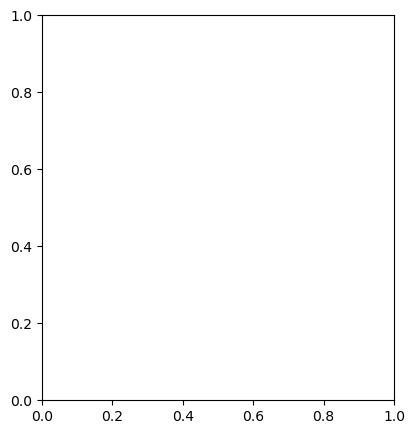

In [61]:
import matplotlib.pyplot as plt

# Plot the training and validation curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(num_iterations), nn.losses, label="Training")
plt.plot(range(num_iterations), nn.val_losses, label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_iterations), nn.train_accuracy, label="Training")
plt.plot(range(num_iterations), nn.val_accuracy, label="Validation")
plt.title("Training and Validation Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20
3/3 [==============================] - 1s 114ms/step - loss: 0.6107 - accuracy: 0.6517 - val_loss: 0.5348 - val_accuracy: 0.7263
Epoch 2/20
3/3 [==============================] - 0s 21ms/step - loss: 0.5068 - accuracy: 0.7697 - val_loss: 0.4719 - val_accuracy: 0.7598
Epoch 3/20
3/3 [==============================] - 0s 28ms/step - loss: 0.4815 - accuracy: 0.7921 - val_loss: 0.4631 - val_accuracy: 0.8156
Epoch 4/20
3/3 [==============================] - 0s 19ms/step - loss: 0.4533 - accuracy: 0.8146 - val_loss: 0.4526 - val_accuracy: 0.8101
Epoch 5/20
3/3 [==============================] - 0s 19ms/step - loss: 0.4509 - accuracy: 0.8118 - val_loss: 0.4532 - val_accuracy: 0.8101
Epoch 6/20
3/3 [==============================] - 0s 19ms/step - loss: 0.4358 - accuracy: 0.8230 - val_loss: 0.4513 - val_accuracy: 0.8045
Epoch 7/20
3/3 [==============================] - 0s 19ms/step - loss: 0.4237 - accuracy: 0.8118 - val_loss: 0.4530 - val_accuracy: 0.7989
Epoch 8/20
3/3 [==========

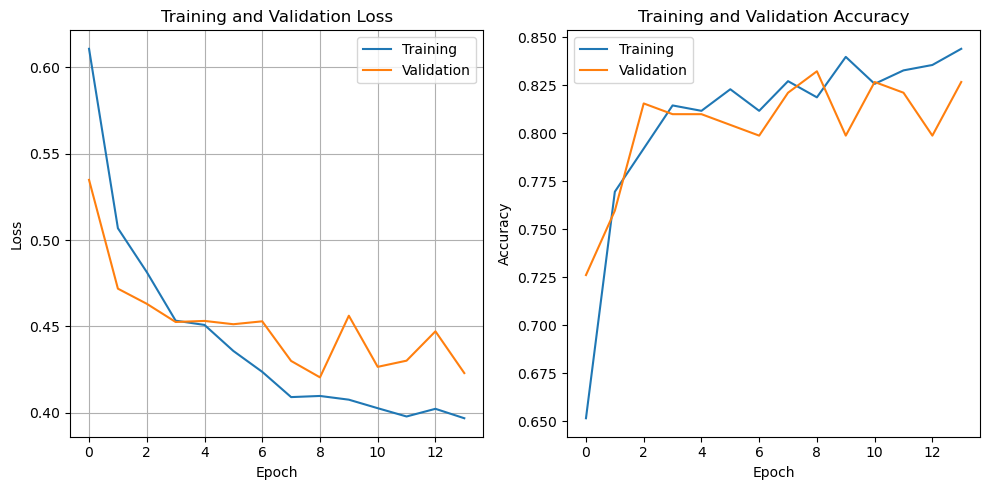

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# Fix the seed for TensorFlow
tf.random.set_seed(42)

# Fix the seed for NumPy
np.random.seed(42)


# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Plot the training and validation curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
test=pd.read_csv('/kaggle/input/titanic/test.csv')

In [67]:
test=pre(test,True)

In [68]:
test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,0.386231,0,0,-0.497811,-0.553443,1,0.0,1.0,0.0,1.0,0.0
1,893,3,1.371370,1,0,-0.512660,0.105643,0,1.0,0.0,0.0,0.0,1.0
2,894,2,2.553537,0,0,-0.464532,-0.553443,1,0.0,1.0,0.0,1.0,0.0
3,895,3,-0.204852,0,0,-0.482888,-0.553443,1,0.0,1.0,0.0,0.0,1.0
4,896,3,-0.598908,1,1,-0.417971,0.764728,0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,-0.204852,0,0,-0.493856,-0.553443,1,0.0,1.0,0.0,0.0,1.0
414,1306,1,0.740881,0,0,1.312180,-0.553443,1,1.0,0.0,1.0,0.0,0.0
415,1307,3,0.701476,0,0,-0.508183,-0.553443,1,0.0,1.0,0.0,0.0,1.0
416,1308,3,-0.204852,0,0,-0.493856,-0.553443,1,0.0,1.0,0.0,0.0,1.0


In [72]:
y_pred = model.predict(test.iloc[:,1:])

14/14 [==============================] - 0s 2ms/step


In [73]:
y_pred

array([[1.08981341e-01],
       [4.34243888e-01],
       [1.00691117e-01],
       [9.29033235e-02],
       [3.19885999e-01],
       [1.25121802e-01],
       [6.48880780e-01],
       [1.36575013e-01],
       [5.87776363e-01],
       [6.79614171e-02],
       [9.23799872e-02],
       [2.14875937e-01],
       [9.75076616e-01],
       [5.20938151e-02],
       [9.92614090e-01],
       [8.78041863e-01],
       [1.68497249e-01],
       [1.90725029e-01],
       [3.92065614e-01],
       [7.47856617e-01],
       [3.09964955e-01],
       [7.16160595e-01],
       [9.78098035e-01],
       [7.86071241e-01],
       [9.76116717e-01],
       [3.96706350e-02],
       [9.77246702e-01],
       [1.83025792e-01],
       [2.30253175e-01],
       [9.45516750e-02],
       [6.89520985e-02],
       [9.66827646e-02],
       [2.21690342e-01],
       [2.20742211e-01],
       [3.99893522e-01],
       [2.02391714e-01],
       [4.05601203e-01],
       [4.13247228e-01],
       [9.71801803e-02],
       [1.46308005e-01],


In [74]:
y_pred_binary = (y_pred > 0.5).astype(int)

In [75]:
# Reshape the arrays to be one-dimensional
passenger_ids = test['PassengerId'].values.flatten()
survived_predictions = y_pred_binary.flatten()

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': survived_predictions
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)